In [268]:
# %connect_info
%qtconsole

In [172]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
from graphgym.custom_graphgym.loader.protein import ProteinDataset
import matplotlib.pyplot as plt
import os

In [160]:
os.chdir('/Users/cgu3/Documents/Grape-Pi')

Import data from csv fies

In [51]:

# dataset = ProteinDataset("../data/yeast-ORBI", numeric_columns=['protein probability'], label_column=None)
# dataset = ProteinBatchDataset("../data/yeast-LCQ", numeric_params=['protein probability'])
# dataset = ProteinBatchDataset("../data/yeast-ORBI-mRNA", numeric_params=['protein probability', 'mRNA(M)'])
# dataset = ProteinBatchDataset("../data/yeast-LCQ-mRNA", numeric_params=['protein probability', 'mRNA(M)'])
# dataset = ProteinDataset("../../data/single-soft-label", numeric_columns=['protein_probability', 'mRNA_TPM'], label_column=None)

In [163]:
df = pd.read_csv('data/single-soft-label/raw/protein/SG_combined_protein_0981_with_soft_label_and_mRNA_TPM.csv')

In [298]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels, ids, train_mask=None, val_mask=None, test_mask=None):
        self.data = data
        self.labels = labels
        self.ids = ids

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample_data = self.data[index]
        sample_label = self.labels[index]
        sample_id = self.ids[index].tolist()
        return sample_data, sample_label, sample_id


In [299]:
x = torch.tensor(df.loc[:, ['protein_probability', 'mRNA_TPM']].values, dtype=torch.float)
y = torch.tensor(df.loc[:, ['protein_probability_soft_label']].values, dtype=torch.float)
ids = df.loc[:, ['protein.Accession']].values

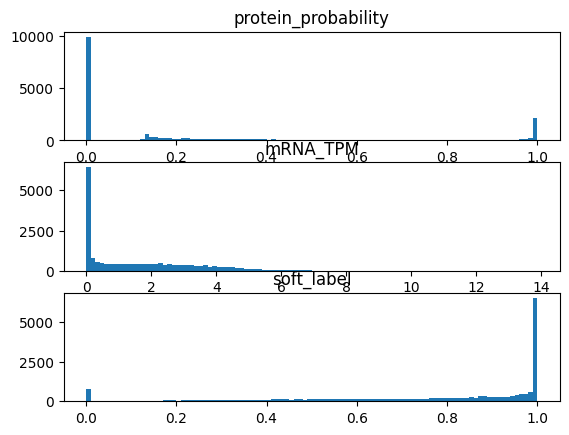

In [300]:
plt.subplot(3, 1, 1)
plt.hist(x[:, 0], bins=100);
plt.title('protein_probability');

plt.subplot(3, 1, 2)
plt.hist(x[:, 1], bins=100);
plt.title('mRNA_TPM');

plt.subplot(3, 1, 3)
plt.hist(y.squeeze(-1), bins=100);
plt.title('soft_label');

In [385]:
protein_dataset = ProteinDataset("data/single-soft-label", numeric_columns=['protein_probability', 'mRNA_TPM'], label_column=None)

In [386]:
from torch.utils.data import Dataset, Subset
dataset = CustomDataset(protein_dataset.x, protein_dataset.y, ids)

train_indices = torch.nonzero(protein_dataset.train_mask).squeeze().tolist()
train_dataset = Subset(dataset, train_indices)

val_indices = torch.nonzero(protein_dataset.val_mask).squeeze().tolist()
val_dataset = Subset(dataset, val_indices)

test_indices = torch.nonzero(protein_dataset.test_mask).squeeze().tolist()
test_dataset = Subset(dataset, test_indices)


In [387]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [388]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score


# define the LightningModule
class MLP(pl.LightningModule):
    def __init__(self, num_features, hidden_channels, num_classes, criterion):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(num_features, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, num_classes)
        # self.lin3 = nn.Linear(hidden_channels, num_classes)
        self.criterion = criterion
        self.val_auroc = BinaryAUROC()
        self.test_auroc = BinaryAUROC()
        # self.val_accuracy = BinaryAccuracy()
        # self.test_accuracy = BinaryAccuracy()
        self.val_F1 = BinaryF1Score()
        self.test_F1 = BinaryF1Score()

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        # x = x.relu()
        # x = self.lin3(x)
        return x

    def get_auc(self, out, target):
        return self.auroc(out, target)

    def training_step(self, batch, batch_idx):
        x, y, id = batch
        logits = self(x).squeeze(-1)  # Perform a single forward pass.

        loss = self.criterion(logits, y)  # Compute the loss solely based on the training nodes.
        values = {"loss": loss}
        self.log_dict(values, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, ids = batch
        logits = self(x).squeeze(-1)  # Perform a single forward pass.
        # self.val_accuracy.update(logits[:, 1], y)
        loss = self.criterion(logits, y)  # Compute the loss solely based on the training nodes.
        # self.val_auroc.update(logits, y)
        # self.val_F1.update(logits, y)
        values = {"val_loss": loss}
        self.log_dict(values, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y, ids = batch
        logits = self(x).squeeze(-1)
        # self.test_accuracy.update(logits[:, 1], y)
        loss = self.criterion(logits, y)
        # self.test_auroc.update(logits, y)
        # self.test_F1.update(logits, y)
        values = {"test_loss": loss}
        self.log_dict(values, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y, ids = batch
        ids = [item for sublist in ids for item in sublist]
        logits = self(x).squeeze(-1)
        pred_prob = torch.nn.functional.sigmoid(logits)
        return (ids, x[:, 0], x[:, 1], pred_prob, y)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer



In [394]:
# init the autoencoder
MLP_model = MLP(1, 20, 1, criterion = torch.nn.BCEWithLogitsLoss())
# MLP_model = MLP(dataset.num_node_features, 10, 2, criterion = torch.nn.CrossEntropyLoss())

In [395]:
import sys
from pytorch_lightning.callbacks import TQDMProgressBar


class MyProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

    def init_predict_tqdm(self):
        bar = super().init_predict_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

    def init_test_tqdm(self):
        bar = super().init_test_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar



In [396]:
trainer = pl.Trainer(limit_train_batches=100, max_epochs=10, callbacks=[MyProgressBar()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [397]:
trainer.fit(model=MLP_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


  | Name       | Type              | Params
-------------------------------------------------
0 | lin1       | Linear            | 40    
1 | lin2       | Linear            | 21    
2 | criterion  | BCEWithLogitsLoss | 0     
3 | val_auroc  | BinaryAUROC       | 0     
4 | test_auroc | BinaryAUROC       | 0     
5 | val_F1     | BinaryF1Score     | 0     
6 | test_F1    | BinaryF1Score     | 0     
-------------------------------------------------
61        Trainable params
0         Non-trainable params
61        Total params
0.000     Total estimated model params size (MB)


/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 105.12it/s, v_num=16, loss=0.509, val_loss=0.497]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 104.41it/s, v_num=16, loss=0.509, val_loss=0.497]


In [398]:
trainer.test(model=MLP_model, dataloaders=test_dataloader)

/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4875957667827606
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4875957667827606}]

In [399]:
out = trainer.predict(MLP_model, dataloaders=test_dataloader)
out

/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [384]:
accession, raw_prob, mRNA, pred_prob, soft_label = zip(*out)
accession = [item for sublist in accession for item in sublist]
raw_prob = [item.item() for sublist in raw_prob for item in sublist]
mRNA = [item.item() for sublist in mRNA for item in sublist]
pred_prob = [item.item() for sublist in pred_prob for item in sublist]
soft_label = [item.item() for sublist in soft_label for item in sublist]
pd.DataFrame({'accession': accession, 'raw_prob': raw_prob, 'mRNA': mRNA, 'pred_prob': pred_prob, 'soft_label': soft_label})

,accession,raw_prob,mRNA,pred_prob,soft_label
0,A0A087X0M5,0.976280,0.000000,0.930853,0.979157
1,A0A087X1C5,0.243009,0.035709,0.700586,0.784043
2,A0A0A6YYL3,0.341797,0.000000,0.744515,0.855166
3,A0A0B4J1V2,0.572661,0.000000,0.836427,0.979623
4,A0A0B4J1X8,0.999882,0.000000,0.934370,0.999882
...,...,...,...,...,...
4080,Q9BXW3,0.000000,4.690594,0.788031,0.982459
4081,Q9HAA7,0.000000,0.000000,0.558771,0.000000
4082,Q9UF83,0.000000,0.000000,0.558771,0.184923
4083,Q9Y6Z2,0.000000,0.053100,0.566573,0.000000


In [102]:
test_dataloader

In [54]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Launching TensorBoard...